# Logistic Regression

In [1]:
#!pip install imblearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src import log_reg_utils

## UDF

## Import Dataset

In [2]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)

In [3]:
accidents.head(2)

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,was_dark_no_lighting,is_day,is_evening,is_morning,is_night,season,is_fall,is_spring,is_summer,is_winter
0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,...,0,1,0,0,0,summer,0,0,1,0
1,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,4.0,...,0,0,0,0,1,spring,0,1,0,0


## Process Data for Model

In [13]:
X = accidents[['crash_month',
              'CRASH_HOUR',
              'is_weekend',
              'has_snow_ice',
              'involved_pedest_cycle',
              'at_intersection',
              'at_stop_sign_or_traffic_light',
              'is_day',
              'is_evening',
              'is_morning',
              'is_night',
               'is_rain',
               'is_sleet_snow',
               'is_spring',
               'is_summer',
               'is_weekend',
               'is_winter']]


y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [14]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.5, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [16]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(solver=solvers, C=c_values)

In [10]:
log_reg = LogisticRegression(max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='precision')

best_model = clf.fit(X_over, y_over)

In [11]:
print('Best Solver: ', best_model.best_estimator_.get_params()['solver'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  newton-cg
Best C:  0.01


### Train and Predict

In [17]:
solver='newton-cg'
c=0.01

log_reg = LogisticRegression(solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[55166  2384]
 [  706   359]]


Recall (Scores FN):  0.3371
Precision (Scores FP):  0.1309
AUC Score:  0.714


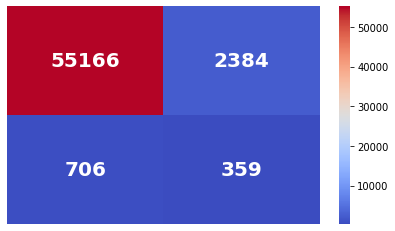

In [18]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [19]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
4,involved_pedest_cycle,2.548083
5,at_intersection,0.481332
6,at_stop_sign_or_traffic_light,0.429803
10,is_night,0.341086
11,is_rain,0.195449
2,is_weekend,0.056327
15,is_weekend,0.056327
12,is_sleet_snow,0.050262
14,is_summer,0.009443
13,is_spring,0.005370


In [20]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -1.0201336244186239


### Test for Multicolinearity

In [21]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='newton')
results.summary()

         Current function value: 0.543448
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
log_reg_utils.calc_vif(X_over_df)